# Clustering Analysis - Song Grouping

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../src')
from preprocessing import load_data, clean_data, scale_features
from clustering import find_optimal_k, apply_kmeans, get_cluster_stats

In [2]:
df_raw = load_data('../data/spotify_2000.csv')
df = clean_data(df_raw)
print(f'Data shape: {df.shape}')

Data shape: (2000, 5)


In [3]:
feature_cols = ['danceability', 'energy', 'tempo']
X_scaled, scaler = scale_features(df, feature_cols)
print('Features scaled successfully')
print(X_scaled.head())

Features scaled successfully
   danceability    energy     tempo
0      0.595254  0.744130 -0.929867
1     -1.662882  1.156685  1.060944
2     -0.986153 -1.469257  0.620779
3     -0.829437  1.261461 -0.004843
4     -0.380660  1.359688  1.948543


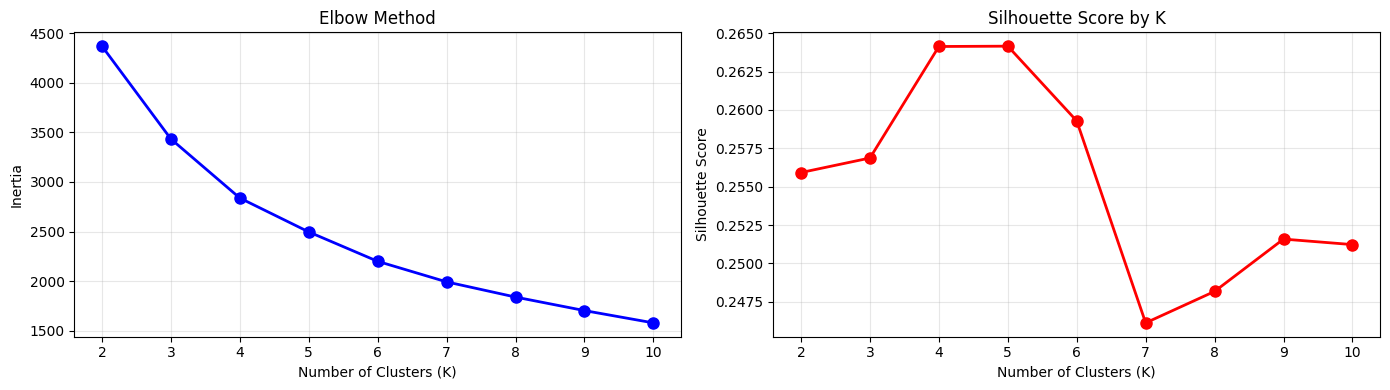

In [4]:
silhouette_scores, inertias = find_optimal_k(X_scaled, k_range=range(2, 11))

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(range(2, 11), inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')
axes[0].grid(True, alpha=0.3)

axes[1].plot(range(2, 11), silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score by K')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [5]:
optimal_k = 3
kmeans, labels = apply_kmeans(X_scaled, n_clusters=optimal_k)
print(f'Clustering with K={optimal_k} completed')
print(f'Cluster distribution:\n{pd.Series(labels).value_counts().sort_index()}')

Clustering with K=3 completed
Cluster distribution:
0    430
1    648
2    922
Name: count, dtype: int64


In [6]:
cluster_stats = get_cluster_stats(X_scaled, labels, feature_cols)
print('\nCluster Statistics (Scaled Features):')
print(cluster_stats.round(3))


Cluster Statistics (Scaled Features):
        danceability        energy         tempo       
                mean    std   mean    std   mean    std
cluster                                                
0             -0.934  0.876  0.238  0.890  1.306  0.793
1              0.417  0.963 -1.056  0.697 -0.459  0.778
2              0.142  0.783  0.631  0.503 -0.287  0.653


In [7]:
df_analysis = df.copy()
df_analysis['cluster'] = labels

print('\nCluster Statistics (Original Features):')
for col in feature_cols:
    print(f'\n{col.upper()}:')
    print(df_analysis.groupby('cluster')[col].agg(['mean', 'std']).round(2))


Cluster Statistics (Original Features):

DANCEABILITY:
         mean   std
cluster            
0        0.54  0.12
1        0.73  0.14
2        0.69  0.11

ENERGY:
         mean   std
cluster            
0        0.76  0.14
1        0.56  0.11
2        0.82  0.08

TEMPO:
           mean    std
cluster               
0        155.33  21.39
1        107.76  20.97
2        112.40  17.62


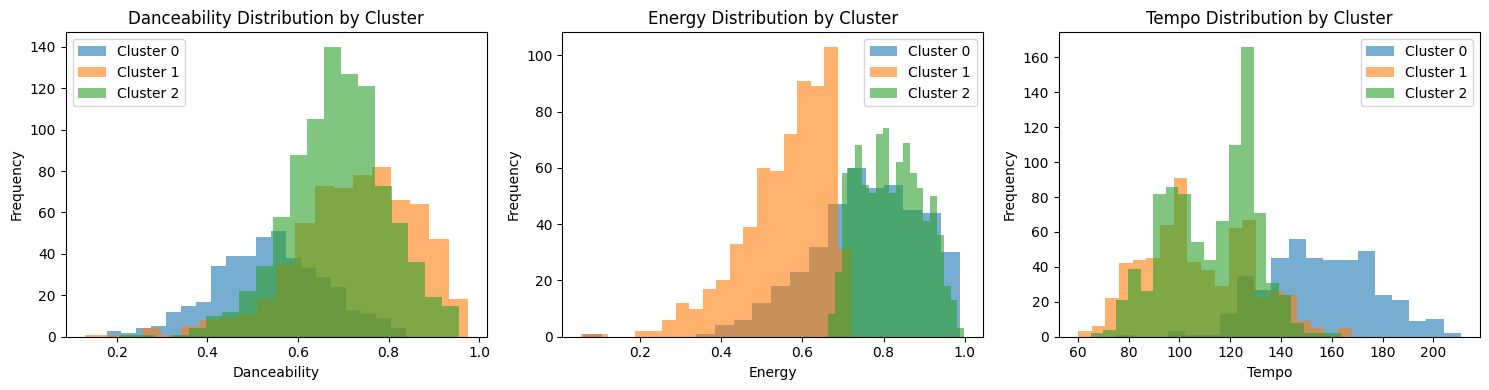

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (ax, feature) in enumerate(zip(axes, feature_cols)):
    for cluster in range(optimal_k):
        cluster_data = df_analysis[df_analysis['cluster'] == cluster][feature]
        ax.hist(cluster_data, alpha=0.6, label=f'Cluster {cluster}', bins=20)
    ax.set_xlabel(feature.capitalize())
    ax.set_ylabel('Frequency')
    ax.set_title(f'{feature.capitalize()} Distribution by Cluster')
    ax.legend()

plt.tight_layout()
plt.show()

In [9]:
cluster_genre = df_analysis.groupby(['cluster', 'primary_genre']).size().unstack(fill_value=0)
print('\nGenre Distribution by Cluster:')
print(cluster_genre)


Genre Distribution by Cluster:
primary_genre  Dance/Electronic  Folk/Acoustic  R&B  World/Traditional  \
cluster                                                                  
0                             8              2    1                  3   
1                             8              0    5                  4   
2                            25              2    7                  3   

primary_genre  country  easy listening  hip hop  latin  metal  pop  rock  \
cluster                                                                    
0                    4               1      130      4      1  203    70   
1                    3               0      315      2      2  279    23   
2                    4               0      331      9      6  454    69   

primary_genre  set()  
cluster               
0                  3  
1                  7  
2                 12  


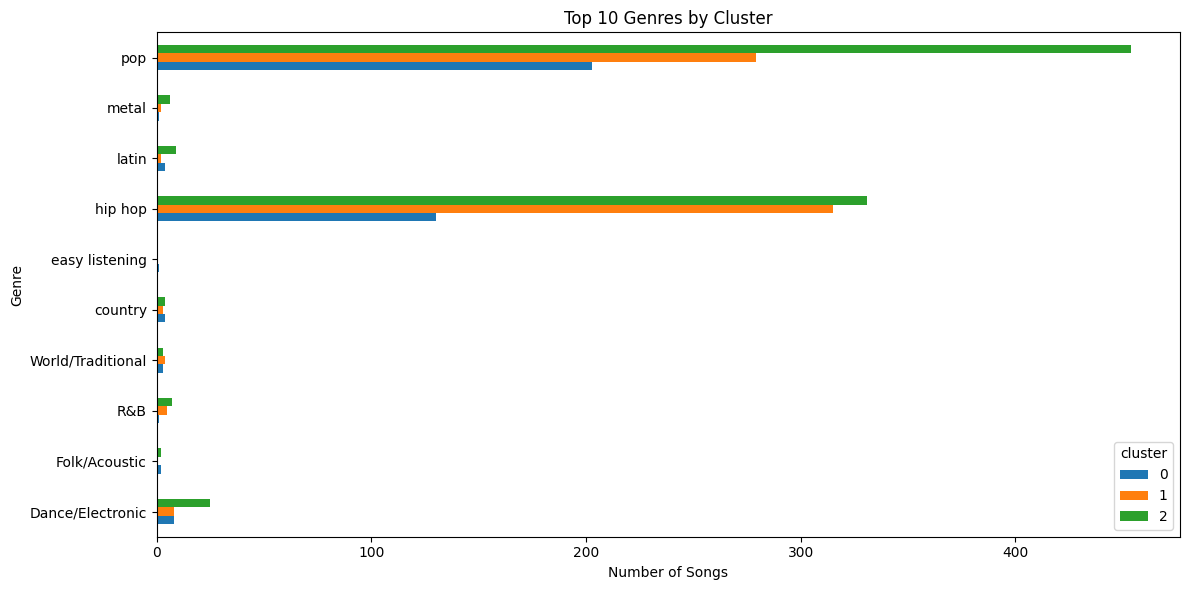

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
cluster_genre.iloc[:, :10].T.plot(kind='barh', ax=ax)
ax.set_xlabel('Number of Songs')
ax.set_ylabel('Genre')
ax.set_title('Top 10 Genres by Cluster')
plt.tight_layout()
plt.show()